# Support vector classifier optimisation: SMO

This notebook demonstrates a custom implementation of the Sequential Minimal Optimisation (SMO) algorithm for training a non-linear support vector classifier. The model is applied to the Scikit-Learn moons dataset, which allows for straightforward visualisation due to its two-dimensional feature space. The data is standardised, class labels are mapped to −1 and 1, and the entire dataset is used to focus solely on the optimisation process rather than model evaluation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

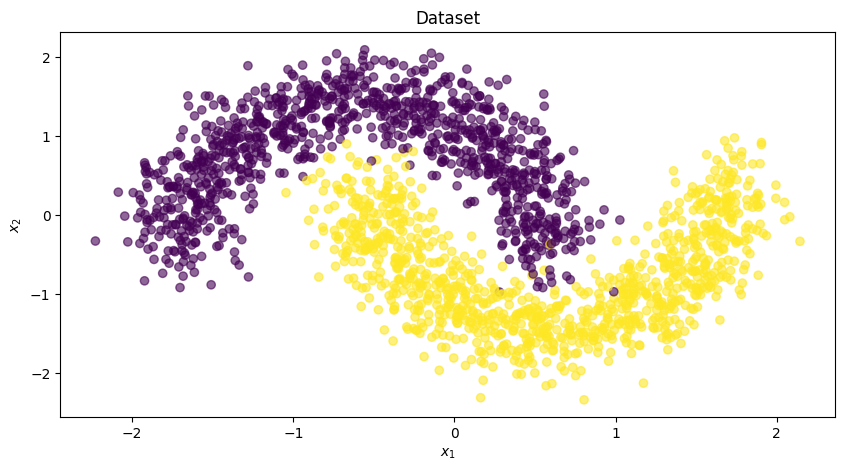

In [3]:
# Dataset creation
X, y = make_moons(n_samples=2000, noise=0.15, random_state=1)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X, y)
y[y == 0] = -1

# Plot the dataset
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(X_scaled[:,0], X_scaled[:,1], c=y, alpha=0.6)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('Dataset');

# Support vector classifier

As already mentioned in the reports, Our Lagrange dual function, $\mathcal{L}_D$, becomes,
\begin{equation}
	\begin{gathered}
		\max_{\alpha} \mathcal{L}_D = \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y_i y_j K(x_i, x_j) \\
		\text{subject to } 0 \leq \alpha_i \leq C, \,\, \sum_{i=1}^N \alpha_i y_i = 0
	\end{gathered}
\end{equation}

Finally, the predicted class label is computed as

\begin{equation}
    \hat{y} = \text{sign} \left( \sum_{i = 1}^N \alpha_i y_i K(x_i, x) + b \right)
\end{equation}

# Implementation

The SMO algorithm trains a support vector classifier by decomposing the original quadratic optimisation problem into a series of simple two-variable updates. Because these paired updates admit a closed-form solution, SMO avoids the need for numerical quadratic programming and large matrix storage. The algorithm is implemented following the procedure outlined in John Platt’s original paper.

In [4]:
def SMO_main(X, y, alphas, b, kernel, C, errors, N):

    alphas_info = np.zeros(N)
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over the whole training set
            for i in range(N):
                res, alphas, b, errors = examine_example(i, X, y, alphas, b, kernel, C, errors, N)
                numChanged += res
            alphas_info = np.vstack((alphas_info, alphas))
        else:
            # loop over examples where alphas are not at bound
            for i in np.where((alphas != 0) & (alphas != C))[0]:
                res, alphas, b, errors = examine_example(i, X, y, alphas, b, kernel, C, errors, N)
                numChanged += res
            alphas_info = np.vstack((alphas_info, alphas))

        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1

    return alphas, b, alphas_info

In [5]:
def examine_example(i2, X, y, alphas, b, kernel, C, errors, N):

    y2 = y[i2]
    alph2 = alphas[i2]
    E2 = errors[i2]
    r2 = E2 * y2

    # Check if error is within tol
    if ((r2 < -tol and alph2 < C) or (r2 > tol and alph2 > 0)):
        if len(alphas[(alphas != 0) & (alphas != C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if errors[i2] > 0:
                i1 = np.argmin(errors)
            elif errors[i2] <= 0:
                i1 = np.argmax(errors)
            res, alphas, b, errors = take_step(i1, i2, X, y, alphas, b, kernel, C, errors, N)

            if res:
                return 1, alphas, b, errors

        # Loop through alpha different from 0 or C
        # Starting randomly
        for i1 in np.roll(np.where((alphas != 0) & (alphas != C))[0], np.random.choice(np.arange(N))):
            res, alphas, b, errors = take_step(i1, i2, X, y, alphas, b, kernel, C, errors, N)
            if res:
                return 1, alphas, b, errors

        # loop through all alphas
        # Starting randomly
        for i1 in np.roll(np.arange(N), np.random.choice(np.arange(N))):
            res, alphas, b, errors = take_step(i1, i2, X, y, alphas, b, kernel, C, errors, N)
            if res:
                return 1, alphas, b, errors

    return 0, alphas, b, errors

In [6]:
def take_step(i1, i2, X, y, alphas, b, kernel, C, errors, N):

    # Stop function if the same alphas are selected
    if i1 == i2:
        return 0, alphas, b, errors

    alph1 = alphas[i1]
    alph2 = alphas[i2]
    y1 = y[i1]
    y2 = y[i2]
    E1 = errors[i1]
    E2 = errors[i2]
    s = y1 * y2

    # Compute the bounds L and H
    # Equations (13) and (14) of the original paper
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(C, C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - C)
        H = min(C, alph1 + alph2)
    if (L == H):
        return 0, alphas, b, errors

    # Evaluate kernel
    k11 = kernel(X[i1], X[i1])
    k12 = kernel(X[i1], X[i2])
    k22 = kernel(X[i2], X[i2])
    eta = k11 + k22 - 2 * k12 # second derivative

    # Compute new alpha_2 if eta is positive
    if (eta > 0):
        a2 = alph2 + y2 * (E1 - E2) / eta
        # Clip a2
        if a2 < L:
            a2 = L
        elif a2 > H:
            a2 = H

    # Change a2 if eta is not positive
    else:
        alphas_modified = alphas.copy()
        alphas_modified[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_modified, y, kernel, X)
        alphas_modified[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_modified, y, kernel, X)

        if Lobj < (Hobj - eps):
            a2 = L
        elif Lobj > (Hobj + eps):
            a2 = H
        else:
            a2 = alph2

    # Stop function if optimisation fails
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, alphas, b, errors

    # Calculate new alpha_1
    a1 = alph1 + s * (alph2 - a2)

    # Update b
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + b

    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average b if at bound for alpha_1 and alpha_2
    else:
        b_new = (b1 + b2) * 0.5

    # Update alpha
    alphas[i1] = a1
    alphas[i2] = a2

    # Update error for alpha_1 and alpha_2
    # Error to 0 if unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < C:
            errors[index] = 0.0

    # Update error for examples that were not optimised
    no_opt = [n for n in range(N) if (n != i1 and n != i2)]
    errors[no_opt] = errors[no_opt] + y1*(a1 - alph1)*kernel(X[i1], X[no_opt]) \
                        + y2*(a2 - alph2)*kernel(X[i2], X[no_opt]) + b - b_new

    # Update b
    b = b_new

    return 1, alphas, b, errors

Defining the objective function.

In [7]:
def objective_function(alphas, y, kernel, x):
    return -np.sum(alphas) + 0.5 * np.sum((y[:, np.newaxis] * y[np.newaxis, :])
                                          * kernel(x, x) * (alphas[:, np.newaxis] * alphas[np.newaxis, :]))

Defining  a function for the Gaussian kernel.

In [8]:
def gaussian_kernel(x, y, sigma=1):
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        return np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        return np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        return np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))

Defining a function to classify the inputs.

In [9]:
def classify_func(alphas, y, kernel, X, x_test, b):
    return (alphas * y) @ kernel(X, x_test) + b

Finally, defining a function which will plot the decision boundary.

In [10]:
def plot_decision_boundary(alphas, X, y, b, kernel, ax):

    # Evaluate model over 100x100 grid
    xrange = np.linspace((X[:,0].min())*1.05, (X[:,0].max())*1.05, 100)
    yrange = np.linspace((X[:,1].min())*1.05, (X[:,1].max())*1.05, 100)
    grid = [[classify_func(alphas, y,kernel, X, np.array([xr, yr]), b) for xr in xrange] for yr in yrange]
    grid = np.array(grid).reshape(len(xrange), len(yrange))

    # Plot the classify function contours using the grid
    ax.contour(xrange, yrange, grid, levels=(-1, 0, 1), linewidths=(1, 1, 1),
               linestyles=('--', '-', '--'), colors=('b', 'k', 'r'))
    # Scatter plot of the dataset
    ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.viridis, lw=0, alpha=0.3)

    # Plot support vectors (circled)
    non_zero_alpha = np.round(alphas, decimals=2) != 0.0
    ax.scatter(X[non_zero_alpha, 0], X[non_zero_alpha, 1], c=y[non_zero_alpha],
               cmap=plt.cm.viridis, lw=1, edgecolors='k')

    return grid, ax

# Testing the algorithm

We start by initialising the model parameters. Although the hyperparameters $C$ and $\sigma$ can be selected using optimisation methods, tuning them is outside the scope of this notebook. The parameter $C$ controls the level of regularisation, with larger values approaching a hard-margin SVM as $C \to \infty$. The Gaussian kernel parameter $\sigma$ determines the kernel width and plays a role similar to the standard deviation of a normal distribution; small values of $\sigma$ may result in overfitting.


In [11]:
# Set model parameters and initial values
X = X_scaled
C = 1 # regularisation constant
N = len(y)
alphas = np.zeros(N) # initial alphas
b = 0.0 # initial b
sigma = 0.5
kernel = lambda x, y: gaussian_kernel(x, y, sigma=sigma)

# Set tolerance parameters
tol = 0.001 # error tolerance
eps = 0.001 # alpha tolerance

# Error initialisation
errors = classify_func(alphas, y, kernel, X, X, b) - y

Now, we train the model and print the training time.

In [12]:
# Model training
time_start = time.time()
alphas, b, alphas_info = SMO_main(X, y, alphas, b, kernel, C, errors, N)
time_end = time.time()

print("The model was trained in " + str(round(time_end - time_start, 2)) + " seconds.")

The model was trained in 14.19 seconds.


Plotting the decision boundary.

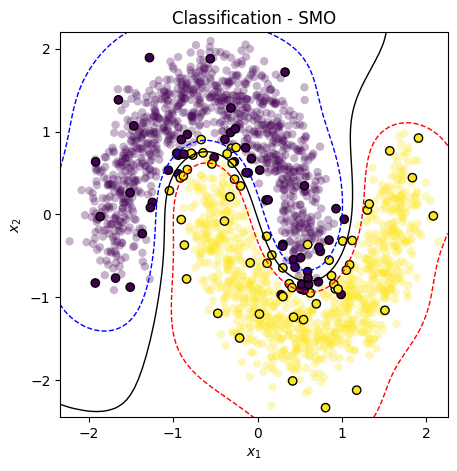

In [15]:
# Plot the decision boundary
fig, ax = plt.subplots(figsize=(5, 5))
grid, ax = plot_decision_boundary(alphas, X, y, b, kernel, ax)
ax.set_title('Classification - SMO')
ax.set_xlim((X[:,0].min())*1.05, (X[:,0].max())*1.05)
ax.set_ylim((X[:,1].min())*1.05, (X[:,1].max())*1.05)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$');

Ploting the confusion matrix which shows the classification result.

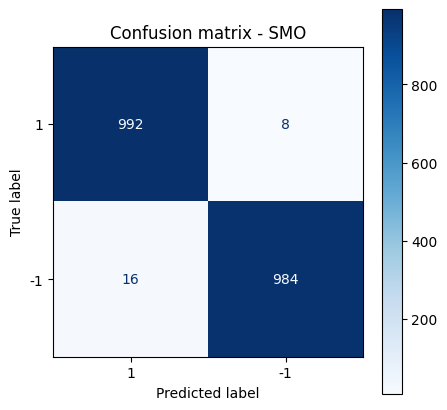

In [73]:
# Predict the class label for each sample
pred = []
for k in range(len(y)):
    check = classify_func(alphas, y, lambda i, j: gaussian_kernel(i, j, sigma=sigma),
                          X, np.array([X[k,0], X[k,1]]), 0)
    pred.append(np.sign(check))

# Create the confusion matrix
cm = confusion_matrix(y, pred)

# Plot the confusion matrix
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
disp = disp.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion matrix - SMO');

# Convergence

Finally, we can analyse the convergence of the algorithm by plotting the Q-convergence. It is done by plotting

\begin{equation}
    \frac{\lVert \alpha_{t + 1} - \alpha^* \rVert}{\lVert \alpha_t - \alpha^* \rVert}
\end{equation}

where $\alpha_t$ is the $\alpha$ vector at iteration $t$ and $\alpha^*$ is the optimal $\alpha$ vector (i.e. the one to which the algorithm has converged).

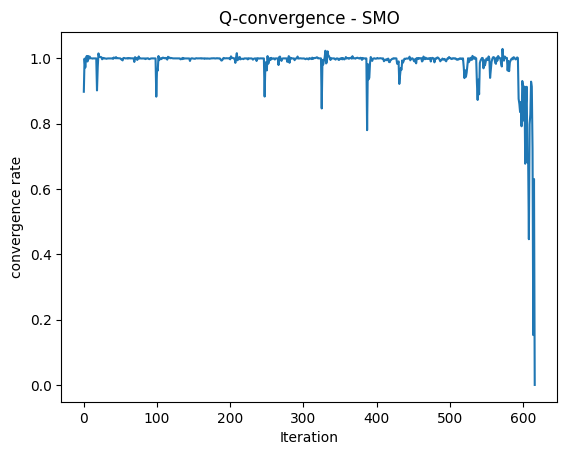

In [74]:
# Compute the norm of the difference between alpha_t and alpha*
c = []
for i in range(len(alphas_info)):
    c.append(np.linalg.norm(alphas_info[i] - alphas_info[-1]))

# Q-convergence plot
fig = plt.figure()
ax = fig.add_subplot(111)
with np.errstate(invalid='ignore'):
    ax.plot(np.divide(c[1:], c[0:-1]))
ax.set_xlabel('Iteration')
ax.set_ylabel('convergence rate')
ax.set_title('Q-convergence - SMO');

We can also investigate the exponential convergence plot by plotting

\begin{equation}
    \ln \left( \lVert \alpha_t - \alpha^* \rVert \right)
\end{equation}

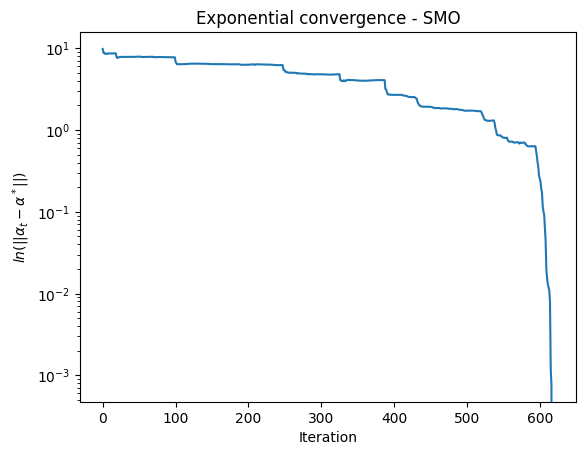

In [75]:
# Exponential convergence plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(c)
ax.set_xlabel('Iteration')
ax.set_ylabel(r'$ln(||\alpha_t - \alpha^*||)$')
ax.set_title('Exponential convergence - SMO');